In [16]:
from tiffConverter import convert_to_numpy, convert_to_tiff
import tomopy
import numpy as np
import matplotlib.pyplot as plt
import cv2
from helperFunctions import subpixel_shift

In [17]:
def cropAndAlign(kevinProj, tomopyProj):
    #Crop to correct region like tomo projection
    w, h = tomopyProj.shape
    res = cv2.matchTemplate(tomopyProj.astype(np.float32),kevinProj.astype(np.float32),cv2.TM_CCOEFF_NORMED)
    loc = np.where( res == res.max())
    print(loc)
    pt = list(zip(*loc[::-1]))[0]
    print(pt)
    kevinProj = kevinProj[pt[1]:w + pt[1] , pt[0]: h+pt[0] ]

    kevinProj = kevinProj[:, 130:-130]
    tomopyProj = tomopyProj[:, 130:-130]

    return kevinProj, tomopyProj

def showHistogramComparison(kevinProj, tomopyProj_scaled):

    plotHeight = 10000
    plotwidth = 0.50

    # Define a common bin range and bin count
    common_range = (min(tomopyProj_scaled.min(), kevinProj.min()), max(tomopyProj_scaled.max(), kevinProj.max()))
    bin_count = 100
    
    # Compute histograms with the same bins
    hist1, bin_edges = np.histogram(tomopyProj_scaled, bins=bin_count, range=common_range)
    hist2, bin_edges = np.histogram(kevinProj, bins=bin_count, range=common_range)
    
    # Subtract the histograms
    hist_diff = hist2 - hist1

    # Plot the difference histogram
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    
    #Plotting
    fig1, axs = plt.subplots(nrows=3, ncols=2, figsize=(8,12))
    axs[0,0].imshow(tomopyProj_scaled)
    axs[0,0].set_title('Tomopy Projection')
    axs[1,0].hist(np.ndarray.flatten(tomopyProj_scaled), bins=bin_edges, alpha=0.5, color = 'blue')
    axs[1,0].set_title('Histogram of Tomopy Projection')
    axs[1,0].set_ylim(0,plotHeight)
    axs[1,0].set_xlim(-plotwidth,plotwidth)
    
    axs[0,1].imshow(kevinProj)
    axs[0,1].set_title('Kevin Projection')
    axs[1,1].hist(np.ndarray.flatten(kevinProj), bins=bin_edges, alpha=0.5, color = 'red')
    axs[1,1].set_title('Histogram of Kevin Projection')
    axs[1,1].set_ylim(0,plotHeight)
    axs[1,1].set_xlim(-plotwidth,plotwidth)
    
    axs[2,0].hist(np.ndarray.flatten(tomopyProj_scaled), bins=bin_edges, alpha=0.5, color = 'blue')
    axs[2,0].hist(np.ndarray.flatten(kevinProj), bins=bin_edges, alpha=0.5, color = 'red')
    axs[2,0].set_ylim(0,plotHeight)
    axs[2,0].set_xlim(-plotwidth,plotwidth)
    axs[2,0].set_title('Both histograms on top of eachother')
    
    
    # axs[2,1].plot(bin_centers, hist_diff, label='Difference (Hist1 - Hist2)', color='green', drawstyle='steps-mid')
    axs[2,1].bar(bin_centers, hist_diff, width=bin_edges[1] - bin_edges[0], alpha=0.5, label='Difference (Hist1 - Hist2)', color='red')
    axs[2,1].legend()
    axs[2,1].set_title('Difference of Histograms (Hist1 - Hist2)')
    axs[2,1].set_ylim(-plotHeight//2,plotHeight//2)
    axs[2,1].set_xlim(-plotwidth,plotwidth)
    
    plt.show()

In [18]:
#Read in Kevin projection for reference
aligned_proj_location = "/Users/levih/Desktop/TomoMono/data/fullTomoReconstructions2.tif"
kevinProjections, kevin_proj_scale_info = convert_to_numpy(aligned_proj_location)

recon_location = "/Users/levih/Desktop/TomoMono/reconstructions/foamRecon_notNormalized_20240731-164829_SIRT_CUDA.tif"
tomo, tomo_scale_info = convert_to_numpy(recon_location)

In [19]:
ang = tomopy.angles(800, 0, 360) #First angle should theoretically be the same no matter how many angles I project through
tomopyProjections = tomopy.project(tomo, ang)

400 550 550


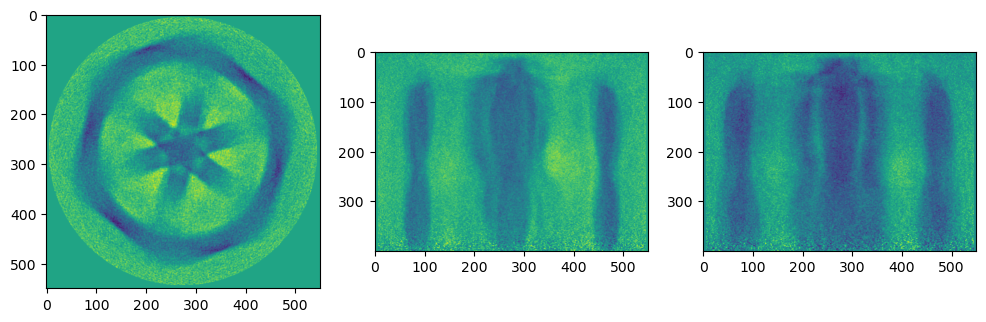

In [20]:
#Volume dimensions
w,h,d = np.shape(tomo)
print(w,h,d)

fig1, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (12,4))

#Dimensions for cropped image (used later for electron density)
# a, b = 160, 520
# c, d = 220, 680
# e, f = 240, 660
a, b = 0, w
c, d = 0, h
e, f = 0, d
axs[0].imshow(tomo[w//2,:,:])
axs[1].imshow(tomo[:,h//2,:])
axs[2].imshow(tomo[:,:,d//2])

tomo = tomo[a:b, c:d, e:f]

## Scale Projections

(array([242]), array([161]))
(161, 242)


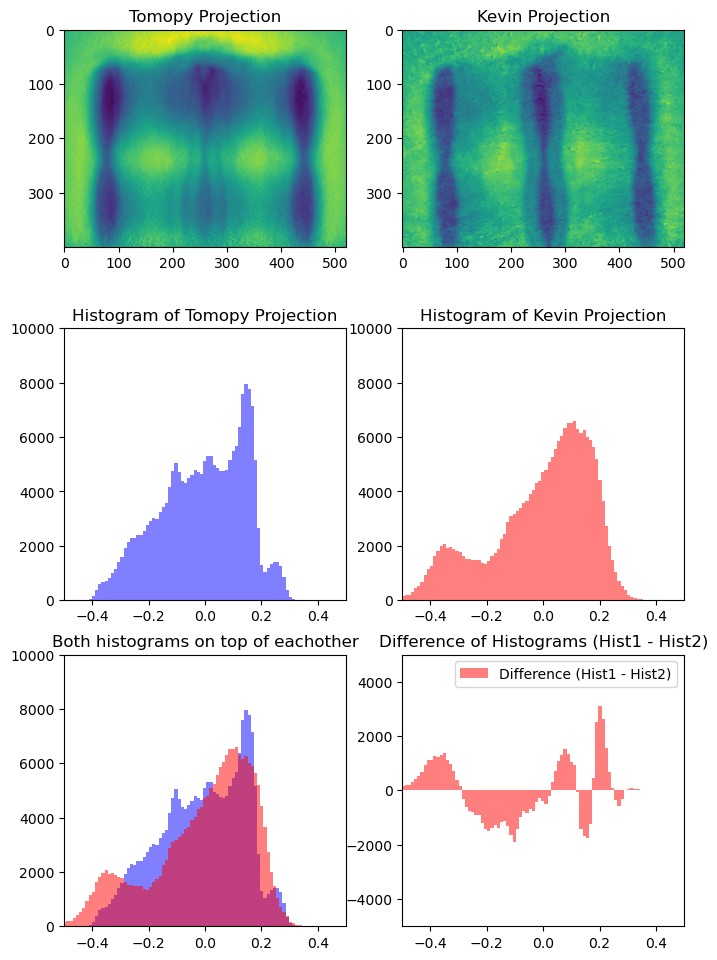

In [21]:
kevinProj, tomopyProj = cropAndAlign(kevinProjections[0], tomopyProjections[0])

# fig1, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (8,4))
# axs[0].imshow(kevinProj)
# axs[1].imshow(tomopyProj)


# # Scale tomopyProj to match kevinProj using Least Squares Fit
flattened_array = tomopyProj.flatten()
flattened_column = flattened_array.reshape(-1,1)

A = np.hstack((np.ones((flattened_array.shape[0],1)), flattened_column))
B = kevinProj.flatten().reshape(-1,1)
X = np.linalg.lstsq(A,B, rcond=None)

shift = X[0][0][0]
scale = X[0][1][0]

tomopyProj = tomopyProj * scale + shift

showHistogramComparison(kevinProj, tomopyProj)

In [22]:
tomo_scaled = tomo.copy()

#Scale all parts of the reconstruction other than the part that is already listed as 
tomo_nonzero_indices = tomo != 0
tomo_scaled[tomo_nonzero_indices] = tomo[tomo_nonzero_indices] * scale + shift

ang = tomopy.angles(800, 0, 360) #First angle should theoretically be the same no matter how many angles I project through
tomopyProjections_scaled = tomopy.project(tomo, ang)

(array([242]), array([161]))
(161, 242)


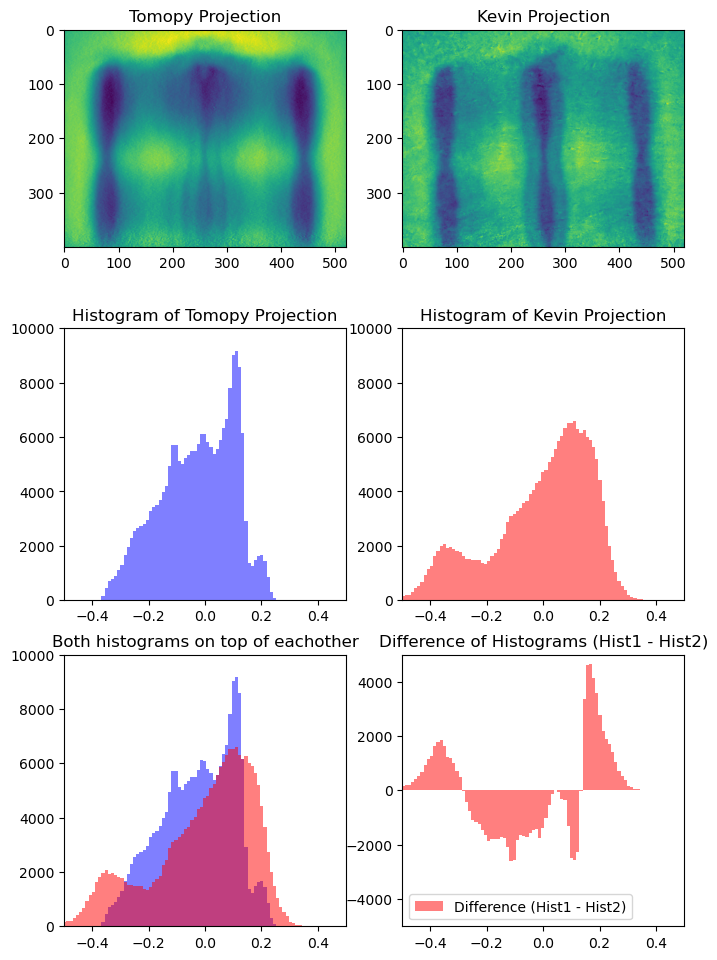

In [23]:
kevinProj, tomopyProj = cropAndAlign(kevinProjections[0], tomopyProjections_scaled[0])
showHistogramComparison(kevinProj, tomopyProj)

## Shift Projections

In [29]:
shifted_values = np.load('shift_values/shiftValues_20240731-140651.npy')

def createDatasetForTory(dataset, shifted_values, kevin_x, kevin_y):
    proj_x = dataset.shape[2]
    proj_y = dataset.shape[1]
    
    delta_x = int((kevin_x-proj_x)/2)
    
    delta_y = (kevin_y - 550)/2
    delta_y2 = 550-400

    newDataset = np.zeros((dataset.shape[0], kevin_y, kevin_x))

    for i in range(dataset.shape[0]):
        # Apply padding to align with tomopyProj
        padded_tomopyProj = np.pad(
            dataset[i],
            ((int(delta_y+delta_y2), int(delta_y)), (delta_x,delta_x)),
            mode='constant',
            constant_values=0
        )

        newDataset[i] = subpixel_shift(padded_tomopyProj, -shifted_values[i,0], -shifted_values[i,1])
        # newDataset[i] = padded_tomopyProj

    return newDataset

In [30]:
print(tomopyProjections.shape)
print(shifted_values.shape)
toryDataset = createDatasetForTory(tomopyProjections_scaled, shifted_values, 1134, 750)

(800, 400, 780)
(800, 2)


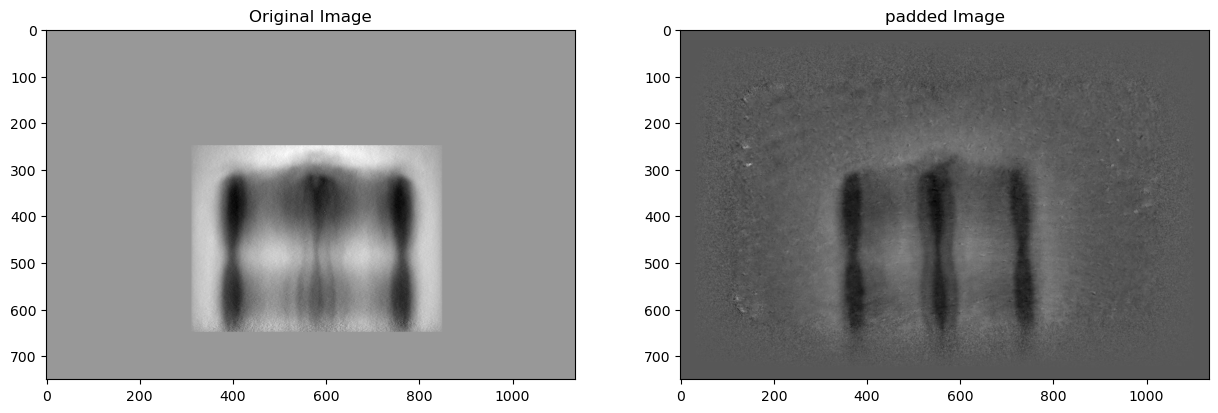

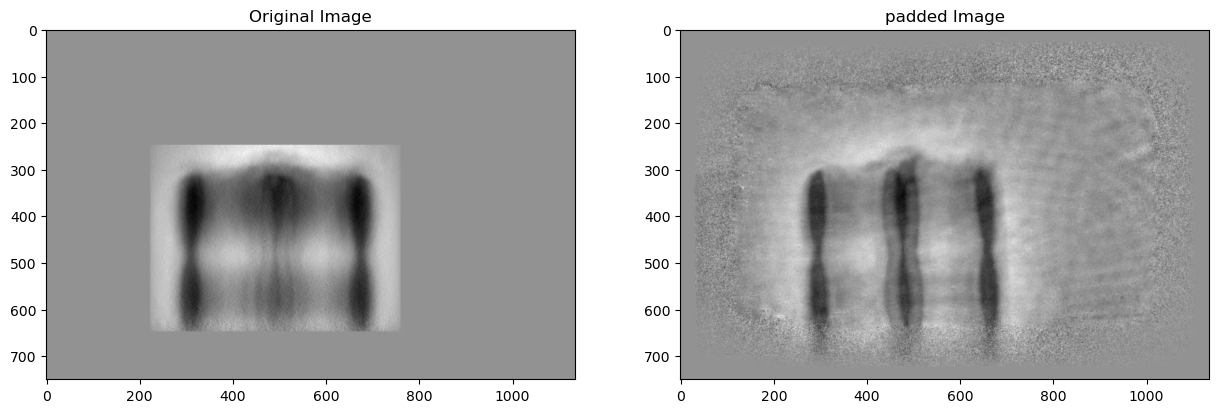

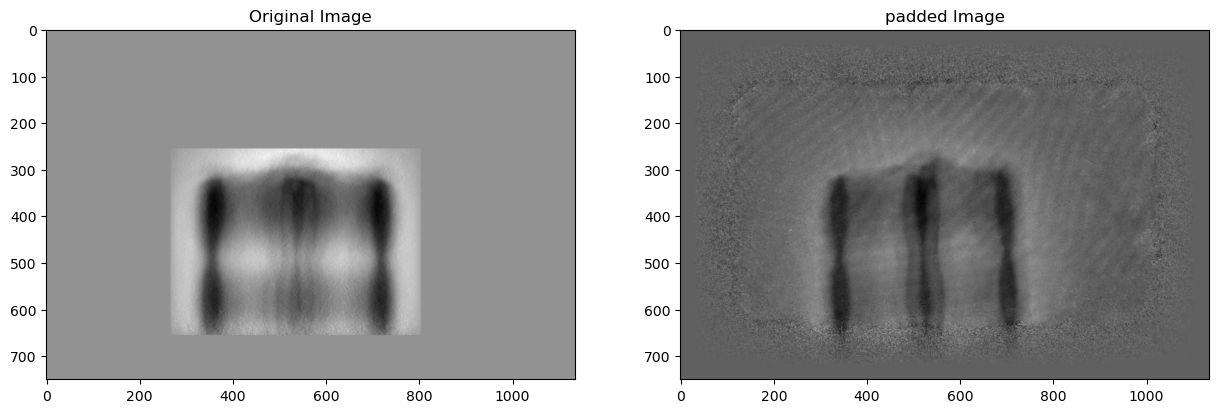

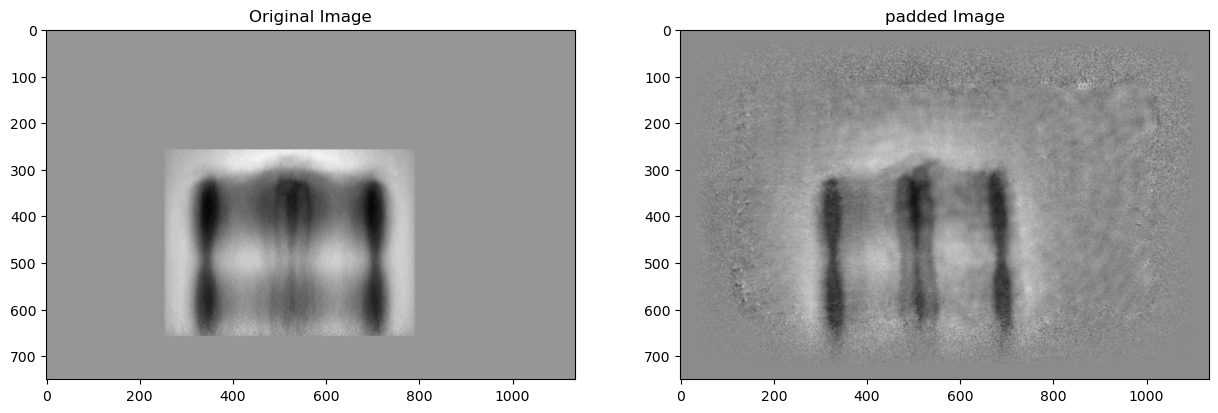

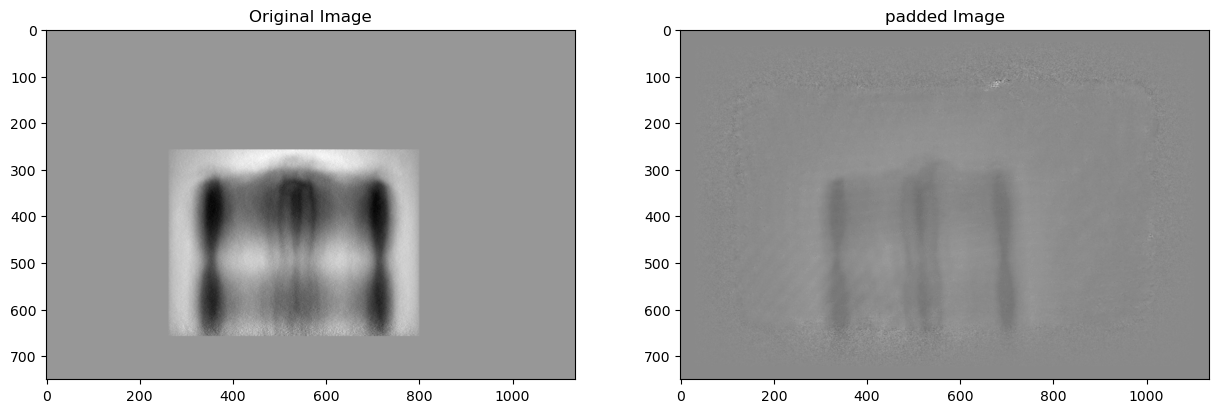

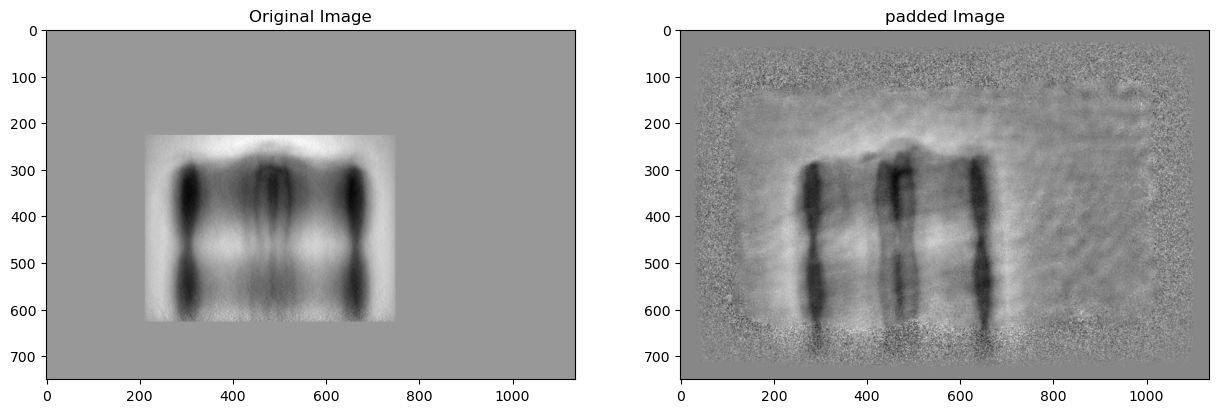

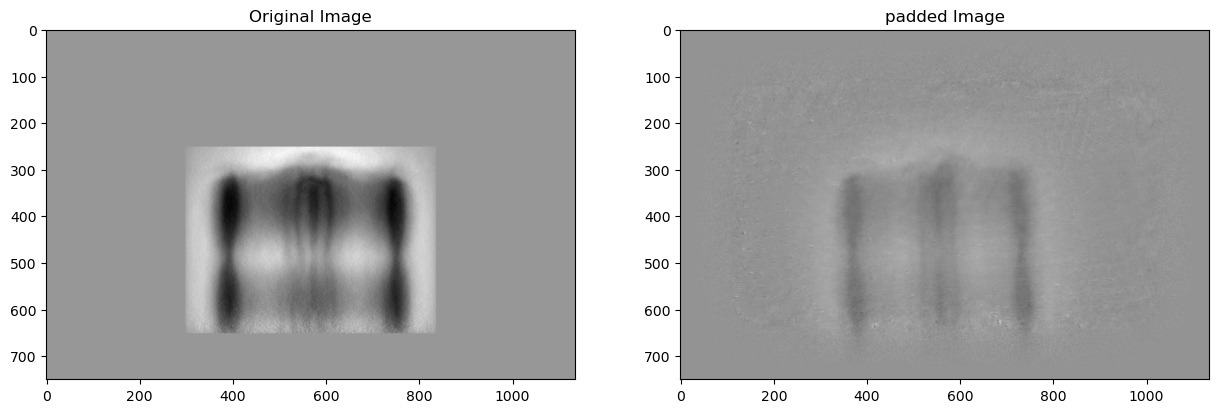

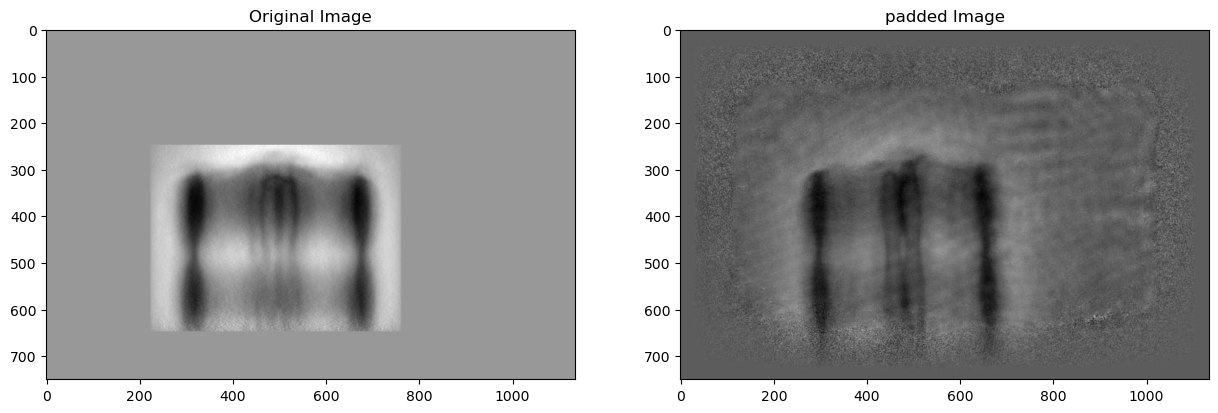

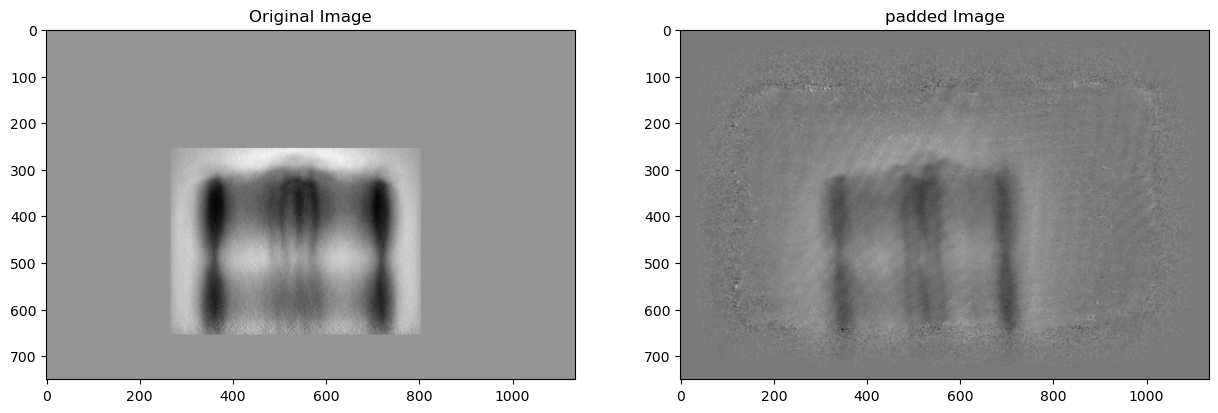

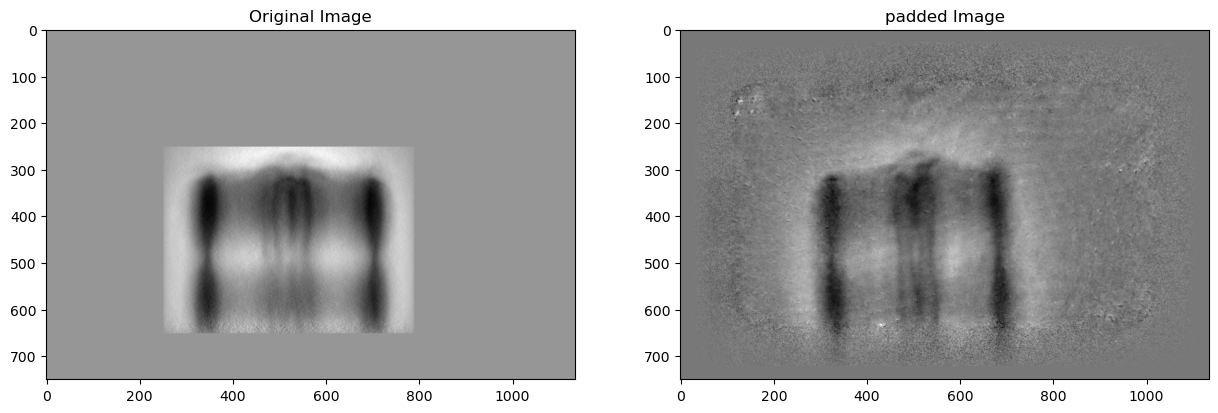

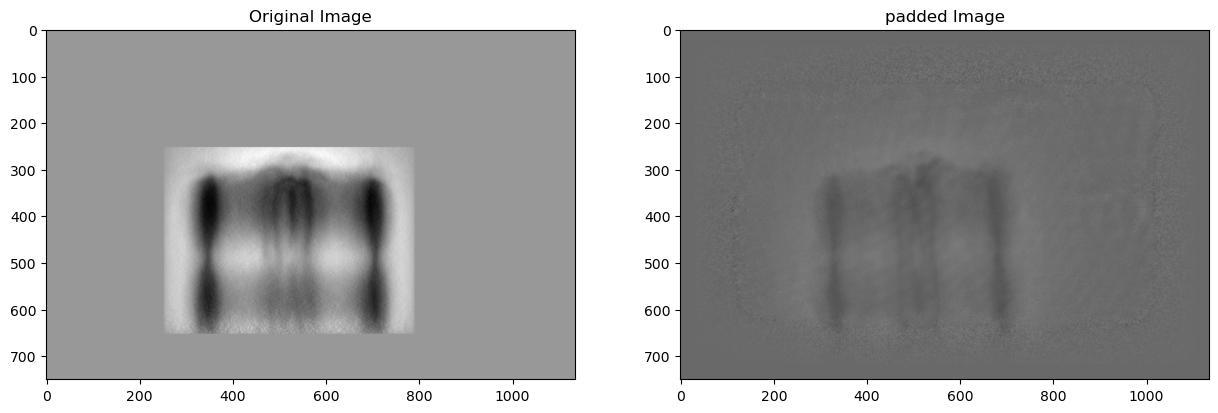

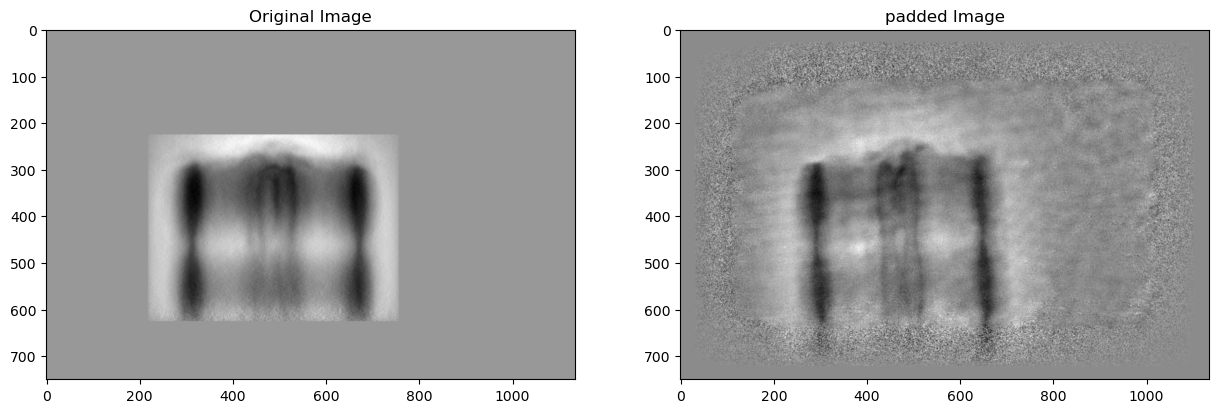

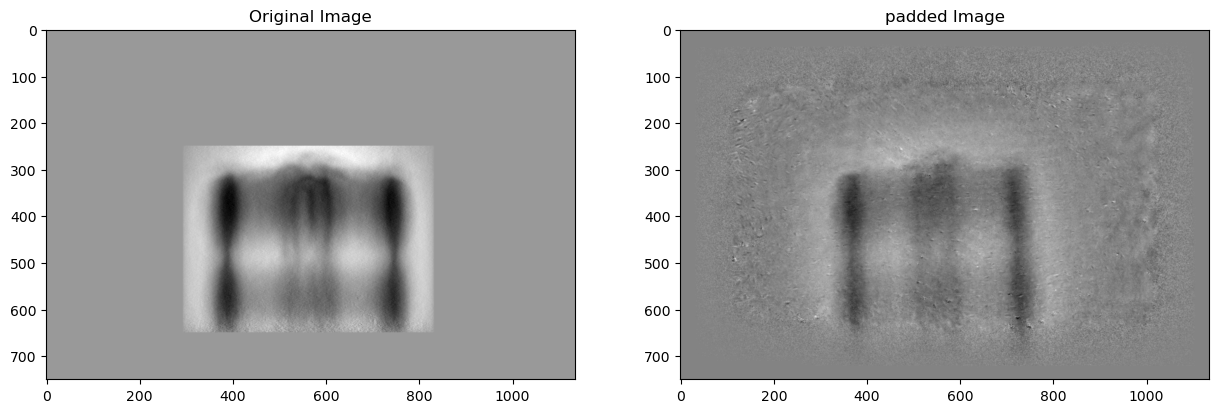

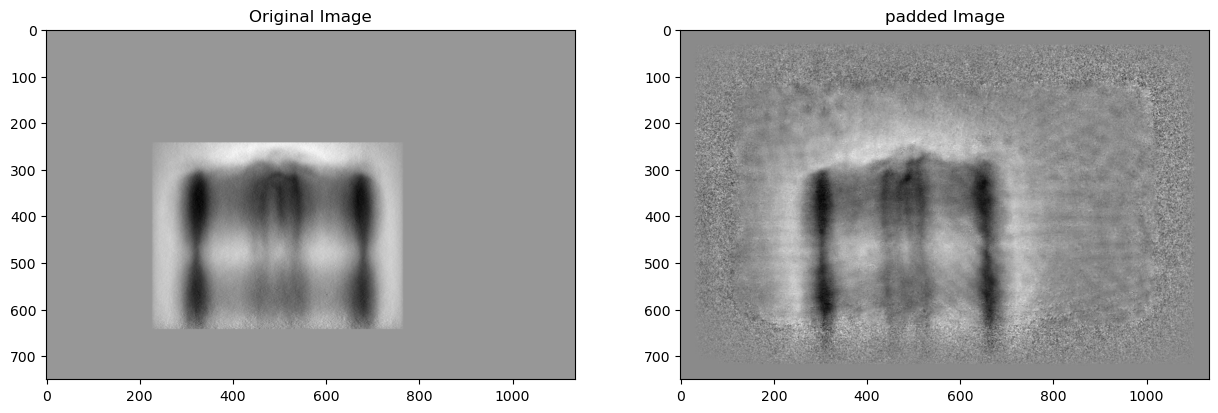

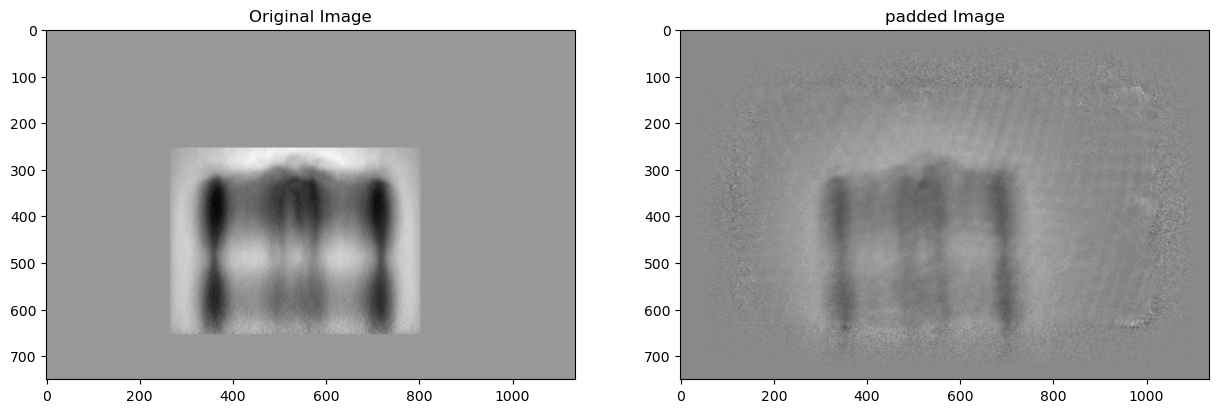

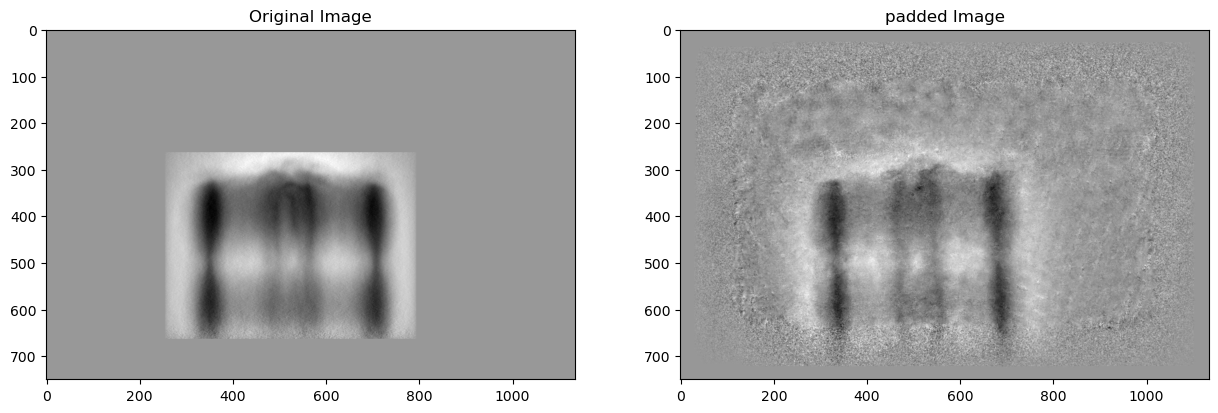

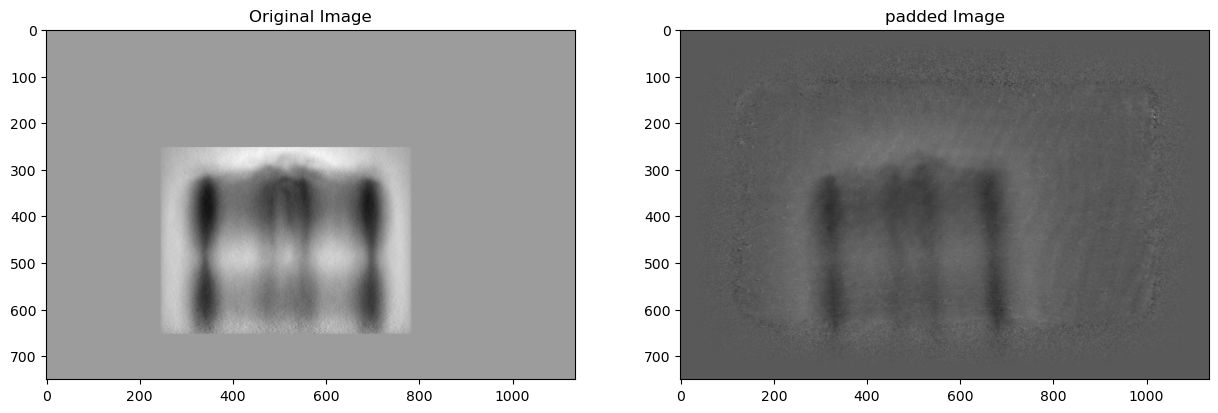

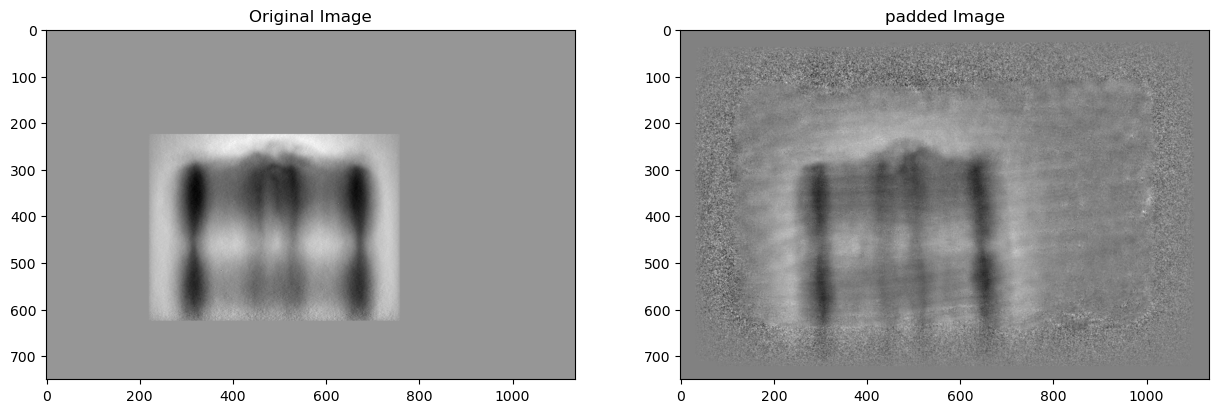

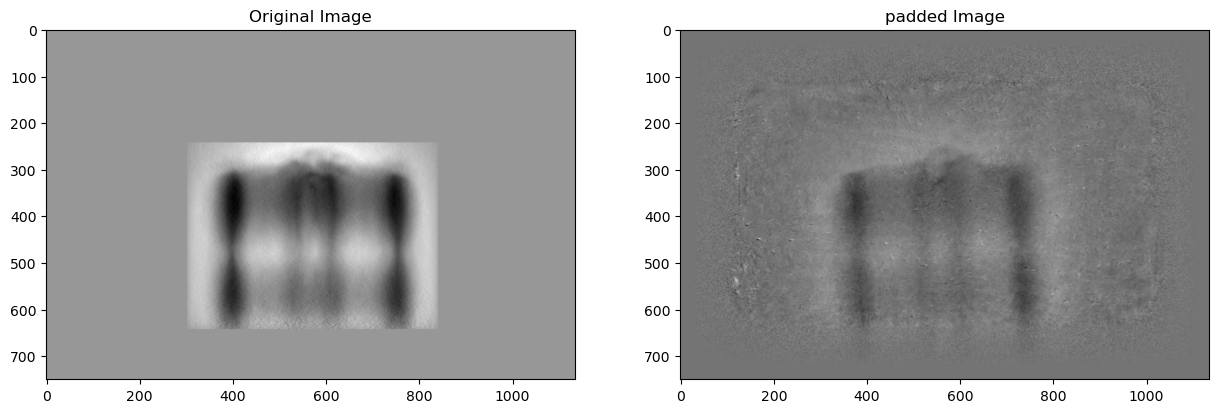

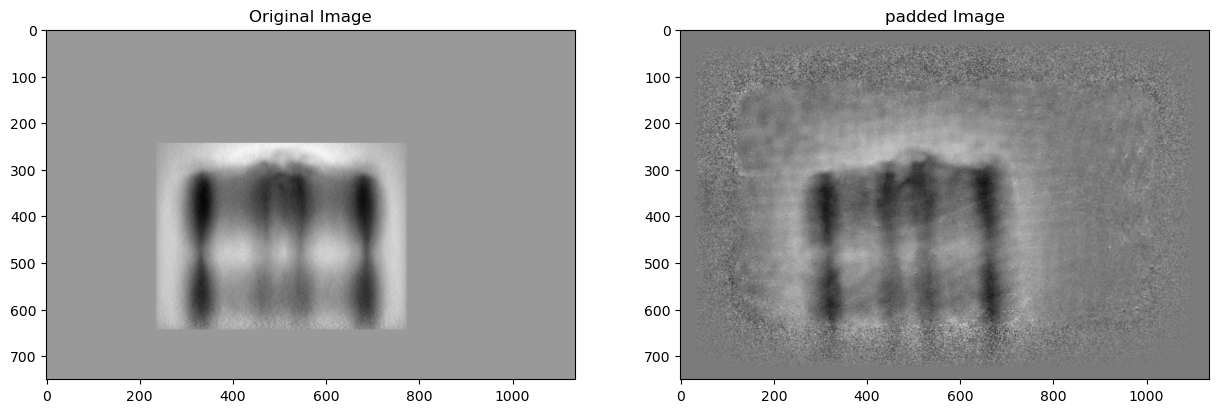

In [31]:
for i in range(20):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(toryDataset[i], cmap='gray')
    plt.subplot(1, 2, 2)
    plt.title("padded Image")
    plt.imshow(kevinProjections[i], cmap='gray')

In [32]:
original_angles = [-179.55, -179.1, -178.65, -178.2, -177.75, -177.3, -176.85, -176.4, -175.95, -175.5, -175.05, -174.6, -174.15, -173.7, -173.25, -172.8, -172.35, -171.9, -171.45, -171.0, -170.55, -170.1, -169.65, -169.2, -168.75, -168.3, -167.85, -167.4, -166.95, -166.5, -166.05, -165.6, -165.15, -164.7, -164.25, -163.8, -163.35, -162.9, -162.45, -162.0, -161.55, -161.1, -160.65, -160.2, -159.75, -159.3, -158.85, -158.4, -157.95, -157.5, -157.05, -156.6, -156.15, -155.7, -155.25, -154.8, -154.35, -153.9, -153.45, -153.0, -152.55, -152.1, -151.65, -151.2, -150.75, -150.3, -149.85, -149.4, -148.95, -148.5, -148.05, -147.6, -147.15, -146.7, -146.25, -145.8, -145.35, -144.9, -144.45, -144.0, -143.55, -143.1, -142.65, -142.2, -141.75, -141.3, -140.85, -140.4, -139.95, -139.5, -139.05, -138.6, -138.15, -137.7, -137.25, -136.8, -136.35, -135.9, -135.45, -135.0, -134.55, -134.1, -133.65, -133.2, -132.75, -132.3, -131.85, -131.4, -130.95, -130.5, -130.05, -129.6, -129.15, -128.7, -128.25, -127.8, -127.35, -126.9, -126.45, -126.0, -125.55, -125.1, -124.65, -124.2, -123.75, -123.3, -122.85, -122.4, -121.95, -121.5, -121.05, -120.6, -120.15, -119.7, -119.25, -118.8, -118.35, -117.9, -117.45, -117.0, -116.55, -116.1, -115.65, -115.2, -114.75, -114.3, -113.85, -113.4, -112.95, -112.5, -112.05, -111.6, -111.15, -110.7, -110.25, -109.8, -109.35, -108.9, -108.45, -108.0, -107.55, -107.1, -106.65, -106.2, -105.75, -105.3, -104.85, -104.4, -103.95, -103.5, -103.05, -102.6, -102.15, -101.7, -101.25, -100.8, -100.35, -99.9, -99.45, -99.0, -98.55, -98.1, -97.65, -97.2, -96.75, -96.3, -95.85, -95.4, -94.95, -94.5, -94.05, -93.6, -93.15, -92.7, -92.25, -91.8, -91.35, -90.9, -90.45, -90.0, -89.55, -89.1, -88.65, -88.2, -87.75, -87.3, -86.85, -86.4, -85.95, -85.5, -85.05, -84.6, -84.15, -83.7, -83.25, -82.8, -82.35, -81.9, -81.45, -81.0, -80.55, -80.1, -79.65, -79.2, -78.75, -78.3, -77.85, -77.4, -76.95, -76.5, -76.05, -75.6, -75.15, -74.7, -74.25, -73.8, -73.35, -72.9, -72.45, -72.0, -71.55, -71.1, -70.65, -70.2, -69.75, -69.3, -68.85, -68.4, -67.95, -67.5, -67.05, -66.6, -66.15, -65.7, -65.25, -64.8, -64.35, -63.9, -63.45, -63.0, -62.55, -62.1, -61.65, -61.2, -60.75, -60.3, -59.85, -59.4, -58.95, -58.5, -58.05, -57.6, -57.15, -56.7, -56.25, -55.8, -55.35, -54.9, -54.45, -54.0, -53.55, -53.1, -52.65, -52.2, -51.75, -51.3, -50.85, -50.4, -49.95, -49.5, -49.05, -48.6, -48.15, -47.7, -47.25, -46.8, -46.35, -45.9, -45.45, -45.0, -44.55, -44.1, -43.65, -43.2, -42.75, -42.3, -41.85, -41.4, -40.95, -40.5, -40.05, -39.6, -39.15, -38.7, -38.25, -37.8, -37.35, -36.9, -36.45, -36.0, -35.55, -35.1, -34.65, -34.2, -33.75, -33.3, -32.85, -32.4, -31.95, -31.5, -31.05, -30.6, -30.15, -29.7, -29.25, -28.8, -28.35, -27.9, -27.45, -27.0, -26.55, -26.1, -25.65, -25.2, -24.75, -24.3, -23.85, -23.4, -22.95, -22.5, -22.05, -21.6, -21.15, -20.7, -20.25, -19.8, -19.35, -18.9, -18.45, -18.0, -17.55, -17.1, -16.65, -16.2, -15.75, -15.3, -14.85, -14.4, -13.95, -13.5, -13.05, -12.6, -12.15, -11.7, -11.25, -10.8, -10.35, -9.9, -9.45, -9.0, -8.55, -8.1, -7.65, -7.2, -6.75, -6.3, -5.85, -5.4, -4.95, -4.5, -4.05, -3.6, -3.15, -2.7, -2.25, -1.8, -1.35, -0.9, -0.45, 0.0, 0.45, 0.9, 1.35, 1.8, 2.25, 2.7, 3.15, 3.6, 4.05, 4.5, 4.95, 5.4, 5.85, 6.3, 6.75, 7.2, 7.65, 8.1, 8.55, 9.0, 9.45, 9.9, 10.35, 10.8, 11.25, 11.7, 12.15, 12.6, 13.05, 13.5, 13.95, 14.4, 14.85, 15.3, 15.75, 16.2, 16.65, 17.1, 17.55, 18.0, 18.45, 18.9, 19.35, 19.8, 20.25, 20.7, 21.15, 21.6, 22.05, 22.5, 22.95, 23.4, 23.85, 24.3, 24.75, 25.2, 25.65, 26.1, 26.55, 27.0, 27.45, 27.9, 28.35, 28.8, 29.25, 29.7, 30.15, 30.6, 31.05, 31.5, 31.95, 32.4, 32.85, 33.3, 33.75, 34.2, 34.65, 35.1, 35.55, 36.0, 36.45, 36.9, 37.35, 37.8, 38.25, 38.7, 39.15, 39.6, 40.05, 40.5, 40.95, 41.4, 41.85, 42.3, 42.75, 43.2, 43.65, 44.1, 44.55, 45.0, 45.45, 45.9, 46.35, 46.8, 47.25, 47.7, 48.15, 48.6, 49.05, 49.5, 49.95, 50.4, 50.85, 51.3, 51.75, 52.2, 52.65, 53.1, 53.55, 54.0, 54.45, 54.9, 55.35, 55.8, 56.25, 56.7, 57.15, 57.6, 58.05, 58.5, 58.95, 59.4, 59.85, 60.3, 60.75, 61.2, 61.65, 62.1, 62.55, 63.0, 63.45, 63.9, 64.35, 64.8, 65.25, 65.7, 66.15, 66.6, 67.05, 67.5, 67.95, 68.4, 68.85, 69.3, 69.75, 70.2, 70.65, 71.1, 71.55, 72.0, 72.45, 72.9, 73.35, 73.8, 74.25, 74.7, 75.15, 75.6, 76.05, 76.5, 76.95, 77.4, 77.85, 78.3, 78.75, 79.2, 79.65, 80.1, 80.55, 81.0, 81.45, 81.9, 82.35, 82.8, 83.25, 83.7, 84.15, 84.6, 85.05, 85.5, 85.95, 86.4, 86.85, 87.3, 87.75, 88.2, 88.65, 89.1, 89.55, 90.0, 90.45, 90.9, 91.35, 91.8, 92.25, 92.7, 93.15, 93.6, 94.05, 94.5, 94.95, 95.4, 95.85, 96.3, 96.75, 97.2, 97.65, 98.1, 98.55, 99.0, 99.45, 99.9, 100.35, 100.8, 101.25, 101.7, 102.15, 102.6, 103.05, 103.5, 103.95, 104.4, 104.85, 105.3, 105.75, 106.2, 106.65, 107.1, 107.55, 108.0, 108.45, 108.9, 109.35, 109.8, 110.25, 110.7, 111.15, 111.6, 112.05, 112.5, 112.95, 113.4, 113.85, 114.3, 114.75, 115.2, 115.65, 116.1, 116.55, 117.0, 117.45, 117.9, 118.35, 118.8, 119.25, 119.7, 120.15, 120.6, 121.05, 121.5, 121.95, 122.4, 122.85, 123.3, 123.75, 124.2, 124.65, 125.1, 125.55, 126.0, 126.45, 126.9, 127.35, 127.8, 128.25, 128.7, 129.15, 129.6, 130.05, 130.5, 130.95, 131.4, 131.85, 132.3, 132.75, 133.2, 133.65, 134.1, 134.55, 135.0, 135.45, 135.9, 136.35, 136.8, 137.25, 137.7, 138.15, 138.6, 139.05, 139.5, 139.95, 140.4, 140.85, 141.3, 141.75, 142.2, 142.65, 143.1, 143.55, 144.0, 144.45, 144.9, 145.35, 145.8, 146.25, 146.7, 147.15, 147.6, 148.05, 148.5, 148.95, 149.4, 149.85, 150.3, 150.75, 151.2, 151.65, 152.1, 152.55, 153.0, 153.45, 153.9, 154.35, 154.8, 155.25, 155.7, 156.15, 156.6, 157.05, 157.5, 157.95, 158.4, 158.85, 159.3, 159.75, 160.2, 160.65, 161.1, 161.55, 162.0, 162.45, 162.9, 163.35, 163.8, 164.25, 164.7, 165.15, 165.6, 166.05, 166.5, 166.95, 167.4, 167.85, 168.3, 168.75, 169.2, 169.65, 170.1, 170.55, 171.0, 171.45, 171.9, 172.35, 172.8, 173.25, 173.7, 174.15, 174.6, 175.05, 175.5, 175.95, 176.4, 176.85, 177.3, 177.75, 178.2, 178.65, 179.1, 179.55, 180.0]

In [33]:
runNumbers = [926, 591, 1340, 911, 1341, 458, 927, 592, 1069, 779, 1342, 459, 928, 593, 1070, 912, 1211, 460, 929, 594, 1071, 781, 1212, 461, 930, 595, 1072, 782, 1213, 462, 931, 596, 1073, 783, 1214, 463, 932, 597, 1074, 784, 1215, 464, 933, 598, 1075, 785, 1216, 465, 934, 599, 1076, 786, 1217, 466, 935, 753, 1077, 787, 1218, 754, 936, 601, 1078, 788, 1219, 468, 937, 602, 1079, 913, 1220, 469, 938, 603, 1080, 790, 1221, 755, 939, 604, 1081, 791, 1222, 471, 940, 605, 1082, 792, 1223, 472, 941, 606, 1083, 793, 1224, 473, 1343, 607, 1084, 794, 1225, 474, 943, 608, 1085, 795, 1226, 475, 1344, 609, 1086, 796, 1227, 476, 945, 610, 1087, 797, 1228, 477, 946, 611, 1088, 798, 1229, 478, 947, 612, 1089, 914, 1230, 479, 948, 613, 1090, 800, 1231, 480, 949, 614, 1091, 801, 1232, 481, 950, 615, 1092, 802, 1233, 482, 951, 616, 1093, 803, 1234, 483, 952, 617, 1094, 804, 1235, 484, 953, 618, 1095, 805, 1236, 756, 954, 619, 1096, 806, 1237, 486, 955, 620, 1097, 807, 1345, 487, 956, 621, 1098, 808, 1239, 488, 957, 622, 1099, 809, 1240, 489, 958, 623, 1100, 810, 1241, 490, 959, 1064, 1101, 811, 1242, 491, 960, 625, 1102, 812, 1243, 492, 961, 626, 1103, 813, 1244, 493, 962, 627, 1104, 814, 1245, 494, 963, 628, 1374, 815, 1375, 495, 964, 915, 1376, 816, 1247, 496, 965, 630, 1107, 817, 1248, 497, 966, 631, 1108, 818, 1249, 498, 967, 632, 1109, 819, 1250, 499, 968, 633, 1110, 820, 1251, 500, 969, 634, 1111, 821, 1252, 501, 970, 635, 1112, 822, 1253, 502, 971, 636, 1113, 823, 1254, 503, 972, 637, 1349, 925, 1255, 504, 973, 638, 1115, 825, 1256, 758, 974, 639, 1116, 826, 1257, 506, 975, 640, 1117, 827, 1258, 507, 976, 641, 1118, 828, 1259, 508, 1377, 642, 1119, 829, 1260, 509, 978, 643, 1120, 830, 1350, 510, 979, 644, 1121, 831, 1262, 511, 1351, 645, 1122, 832, 1263, 512, 981, 646, 1123, 833, 1264, 513, 982, 647, 1124, 834, 1265, 514, 983, 648, 1125, 835, 1266, 515, 984, 649, 1126, 836, 1267, 516, 985, 759, 1127, 837, 1268, 517, 986, 651, 1128, 838, 1269, 518, 987, 652, 1129, 839, 1270, 519, 988, 653, 1130, 840, 1271, 760, 989, 654, 1131, 841, 1272, 761, 990, 655, 1132, 842, 1273, 522, 991, 656, 1133, 843, 1274, 523, 992, 657, 1134, 1065, 1275, 524, 993, 658, 1135, 845, 1352, 762, 994, 659, 1353, 846, 1378, 526, 995, 660, 1137, 847, 1278, 763, 996, 661, 1138, 848, 1279, 528, 997, 662, 1139, 849, 1280, 764, 998, 663, 1140, 850, 1281, 530, 999, 664, 1141, 851, 1282, 531, 1000, 665, 1142, 852, 1283, 532, 1001, 666, 1143, 853, 1284, 533, 1002, 667, 1144, 854, 1285, 534, 1003, 668, 1145, 855, 1286, 535, 1004, 669, 1146, 856, 1287, 536, 1005, 670, 1147, 857, 1379, 537, 1006, 671, 1148, 858, 1289, 538, 1007, 672, 1149, 859, 1290, 539, 1008, 673, 1150, 860, 1291, 540, 1009, 674, 1380, 861, 1292, 541, 1010, 675, 1152, 924, 1293, 542, 1011, 676, 1153, 863, 1294, 543, 1357, 677, 1154, 864, 1295, 544, 1013, 678, 1155, 865, 1296, 545, 1014, 679, 1156, 866, 1297, 546, 1015, 766, 1157, 867, 1298, 547, 1016, 767, 1158, 919, 1299, 548, 1017, 682, 1159, 869, 1300, 549, 1018, 683, 1160, 870, 1301, 550, 1358, 684, 1161, 871, 1302, 551, 1359, 685, 1162, 872, 1303, 768, 1360, 686, 1163, 873, 1304, 553, 1022, 687, 1164, 874, 1305, 1361, 1023, 688, 1165, 875, 1362, 555, 1024, 689, 1166, 876, 1307, 556, 1025, 690, 1167, 877, 1308, 1066, 1026, 691, 1168, 878, 1309, 558, 1027, 692, 1169, 879, 1310, 559, 1028, 693, 1170, 880, 1311, 560, 1029, 694, 1171, 881, 1312, 561, 1030, 695, 1172, 882, 1313, 562, 1363, 696, 1173, 883, 1314, 563, 1032, 697, 1174, 884, 1315, 564, 1033, 698, 1175, 885, 1316, 565, 1034, 699, 1176, 886, 1317, 920, 1035, 729, 1177, 887, 1318, 770, 1036, 730, 1178, 921, 1319, 568, 1037, 731, 1179, 889, 1320, 569, 1038, 732, 1180, 890, 1381, 570, 1039, 733, 1181, 891, 1322, 571, 1040, 734, 1182, 892, 1323, 771, 1041, 735, 1183, 893, 1324, 772, 1042, 736, 1184, 894, 1325, 574, 1043, 737, 1185, 895, 1326, 575, 1044, 773, 1186, 896, 1327, 576, 1045, 739, 1187, 897, 1328, 577, 1046, 740, 1188, 898, 1329, 578, 1047, 741, 1189, 899, 1330, 579, 1048, 742, 1190, 900, 1331, 580, 1049, 743, 1191, 901, 1332, 581, 1050, 744, 1192, 902, 1333, 582, 1051, 745, 1193, 903, 1334, 583, 1052, 746, 1194, 904, 1382, 584, 1053, 747, 1195, 922, 1366, 774, 1054, 748, 1196, 906, 1367, 775, 1055, 923, 1197, 907, 1368, 587, 1056, 750, 1198, 908, 1369, 588, 1057, 751, 1199, 909, 1370, 1371, 1058, 752, 1200, 910, 1372, 590, 1059, 1067]

In [127]:
import tifffile
for i in range(800):
    file_location = f"2D_Seed/ProjectionThrough3D_angle{original_angles[i]}_run{runNumbers[i]}.tif"
    tifffile.imsave(file_location, toryDataset[i])


/var/folders/9j/rgm19f9j2zl4zlr360cyh7s5671yh5/T/ipykernel_13121/881437503.py:4: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tifffile.imsave(file_location, toryDataset[i])
